##Parte 2: EXPERIMENTO 1

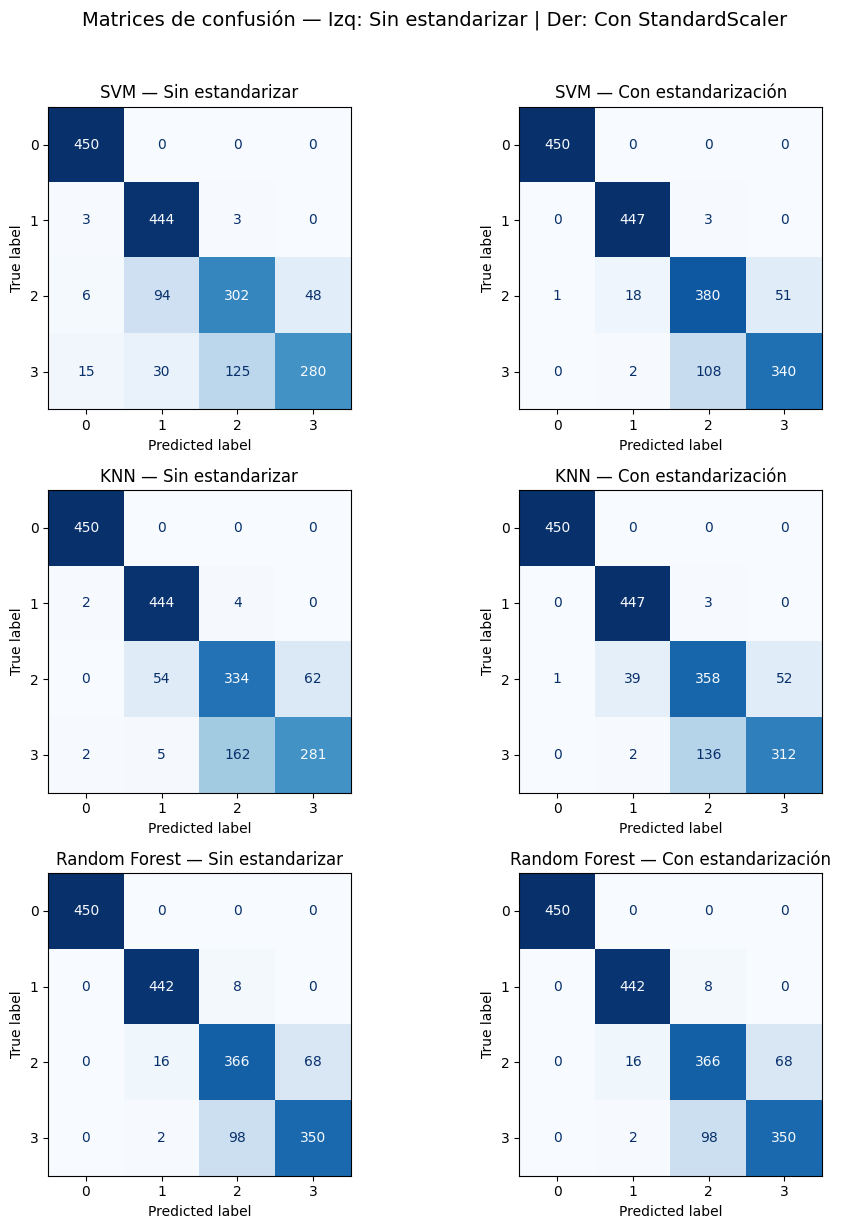

In [4]:
# EXPERIMENTO 1
# Objetivo: evaluar el efecto de la estandarización (StandardScaler)
# sobre modelos sensibles a escala (SVM, KNN) vs. un modelo
# basado en árboles (Random Forest), cuando las 5 variables
# tienen escalas diferentes entre sí.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Configuración general
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = (12, 12)

# Fijamos semilla para reproducibilidad en TODA la generación aleatoria
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

# Datos sintéticos: 4 clases con esclas distintas
# Definimos manualmente 5 características (columnas) y 4 clases (filas).
# Cada fila es el "centro" (media multivariada) de una clase.
centers = np.array([
    [120, 55, 30, 0.20, 4.0],
    [130, 60, 20, 0.50, 6.0],
    [140, 65, 12, 0.75, 8.0],
    [150, 68,  6, 0.90, 10.0],
], dtype=float)

# Matriz de covarianza base (diagonal, variables independientes),
# con varianzas muy distintas para inducir escalas heterogéneas.
cov_base = np.diag([25.0, 9.0, 9.0, 0.02, 0.6])

# Escala por clase (dispersión relativa). A mayor "scale", mayor varianza
# alrededor del centro; esto añade dificultad y asimetría entre clases.
scales = np.array([0.3, 1.0, 3.0, 5.0], dtype=float)

def gen_data_per_class(n_per_class, centers, scales, cov_base):
    """
    Genera n_per_class muestras por cada clase a partir de una
    Normal multivariada N(mu, (s^2) * cov_base). Separamos por clase
    para poder controlar la dispersión (scales) de forma diferenciada.
    """
    X_list, y_list = [], []
    for c, (mu, s) in enumerate(zip(centers, scales)):
        cov = (s**2) * cov_base
        # check_valid='ignore' evita warnings por matrices casi-singulares
        Xi = rng.multivariate_normal(mu, cov, size=n_per_class, check_valid='ignore')
        yi = np.full(n_per_class, c, dtype=int)
        X_list.append(Xi)
        y_list.append(yi)
    return np.vstack(X_list), np.concatenate(y_list)

# Número de muestras por clase (balanceado en cantidad, pero no en escala)
N_PER_CLASS = 1500  # total = 6000
X, y = gen_data_per_class(N_PER_CLASS, centers, scales, cov_base)

# ---- 2) Split y estandarización ----
# Estratificamos para mantener la misma proporción de clases en train/test.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RNG_SEED
)

# Ajustamos StandardScaler SOLO con train (evita data leakage)
# y lo aplicamos a train y test con los mismos parámetros.
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

# 3) Modelos
# SVC(kernel='rbf'): kernel RBF es un estándar fuerte para datos no lineales.
#   C=1.0: regularización por defecto (compromiso margen/errores).
#   gamma='scale': gamma = 1/(n_features * var(X)) (más estable que 'auto').
# KNN(n_neighbors=5): k=5 es un valor clásico que reduce ruido respecto a k=1.
# RandomForest(n_estimators=300): más árboles suelen estabilizar el voto;
#   300 ofrece baja varianza sin costos excesivos en este tamaño de datos.
modelos = {
    "SVM": SVC(kernel='rbf', C=1.0, gamma='scale', random_state=RNG_SEED),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=RNG_SEED)
}

#  4) Gráficas: 3 filas × 2 columnas
# Para cada modelo: izquierda SIN escalar, derecha CON StandardScaler.
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.suptitle("Matrices de confusión — Izq: Sin estandarizar | Der: Con StandardScaler", fontsize=14, y=1.02)

for i, (nombre, modelo) in enumerate(modelos.items()):
    # Sin estandarizar
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=axes[i, 0], cmap="Blues", colorbar=False)
    axes[i, 0].set_title(f"{nombre} — Sin estandarizar")
    axes[i, 0].grid(False)

    # Con estandarización
    # Clonamos el modelo para no contaminar el primero y mantener exactamente
    # los mismos hiperparámetros en ambas condiciones. Reponemos random_state
    # cuando aplica para asegurar reproducibilidad.
    modelo2 = type(modelo)(**modelo.get_params())
    if hasattr(modelo2, "random_state"):
        modelo2.set_params(random_state=RNG_SEED)
    modelo2.fit(X_train_std, y_train)
    y_pred_s = modelo2.predict(X_test_std)
    cm_s = confusion_matrix(y_test, y_pred_s)
    disp_s = ConfusionMatrixDisplay(cm_s)
    disp_s.plot(ax=axes[i, 1], cmap="Blues", colorbar=False)
    axes[i, 1].set_title(f"{nombre} — Con estandarización")
    axes[i, 1].grid(False)

plt.tight_layout()
plt.show()


PUNOTO 2. EXPERIMENTO 2

Outliers inyectados en TRAIN: 1200 (~300 por clase)


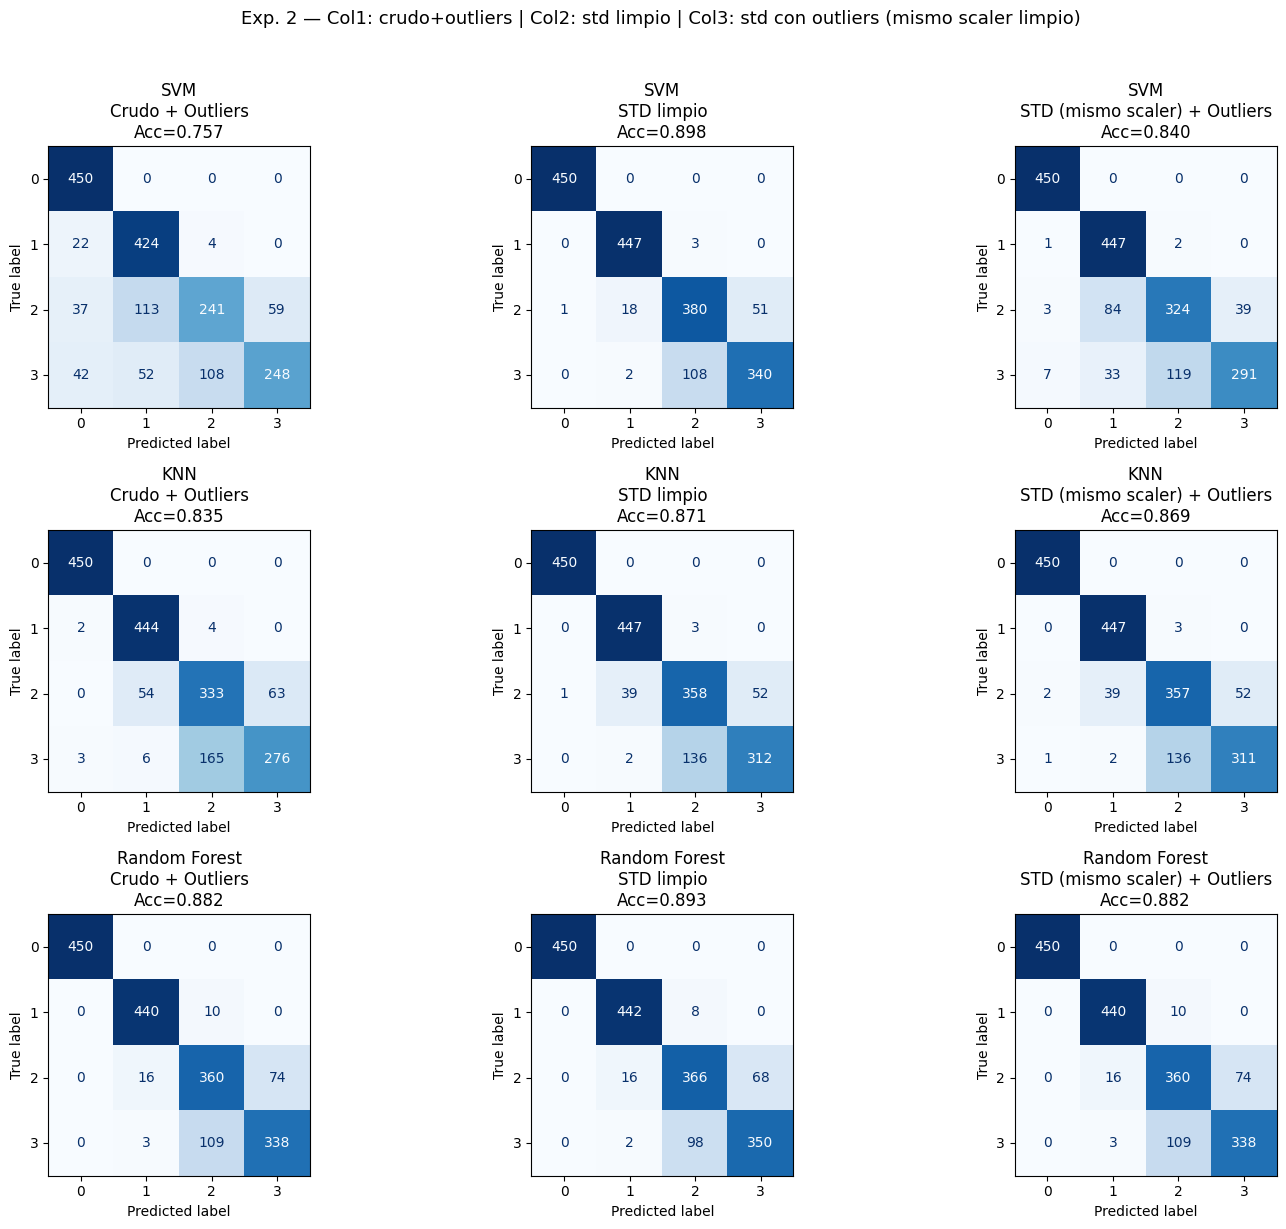

In [5]:
# EXPERIMENTO 2
# Objetivo: analizar cómo los valores atípicos (outliers) afectan
# el rendimiento de SVM, KNN y Random Forest, comparando tres
# escenarios: datos crudos con outliers, estandarización limpia,
# y estandarización con outliers (sin reajustar el escalador).


import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

#  Config general
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = (12, 12)
RNG_SEED = 42  # semilla para reproducibilidad
rng = np.random.default_rng(RNG_SEED)

# Datos sintéticos base
# Se reutiliza la misma estructura del Experimento 1 (4 clases, 5 variables)
centers = np.array([
    [120, 55, 30, 0.20, 4.0],
    [130, 60, 20, 0.50, 6.0],
    [140, 65, 12, 0.75, 8.0],
    [150, 68,  6, 0.90, 10.0],
], dtype=float)

# Covarianza diagonal: independencia entre variables
cov_base = np.diag([25.0, 9.0, 9.0, 0.02, 0.6])
# Escalas distintas por clase (heterogeneidad en dispersión)
scales = np.array([0.3, 1.0, 3.0, 5.0], dtype=float)

def gen_data_per_class(n_per_class, centers, scales, cov_base, rng):
    """
    Genera datos normales multivariados por clase,
    controlando varianza mediante el factor de escala (scales).
    """
    X_list, y_list = [], []
    for c, (mu, s) in enumerate(zip(centers, scales)):
        cov = (s**2) * cov_base
        Xi = rng.multivariate_normal(mu, cov, size=n_per_class, check_valid='ignore')
        yi = np.full(n_per_class, c, dtype=int)
        X_list.append(Xi)
        y_list.append(yi)
    return np.vstack(X_list), np.concatenate(y_list)

# Generamos 6000 muestras balanceadas (1500 por clase)
N_PER_CLASS = 1500
X, y = gen_data_per_class(N_PER_CLASS, centers, scales, cov_base, rng)

#  Split base
# Se separan datos en train/test (70/30) de forma estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RNG_SEED
)

#  Inyección de OUTLIERS
def inject_outliers_train(X_train, y_train, n_outliers_per_class, rng,
                          factor_range=(2.0, 4.0), dims_per_outlier=2):
    """
    Inyecta valores atípicos (outliers) en el conjunto de entrenamiento.
    - Se eligen 'dims_per_outlier' variables aleatorias por clase.
    - Su valor medio se multiplica por un factor aleatorio entre 2x y 4x.
    - Se añade ruido gaussiano leve en las demás variables.
    Esto simula errores de medición o valores extremos.
    """
    X_out, y_out = [], []
    classes = np.unique(y_train)
    for c in classes:
        Xc = X_train[y_train == c]
        mu = Xc.mean(axis=0)
        sd = Xc.std(axis=0, ddof=1)
        d = Xc.shape[1]
        for _ in range(n_outliers_per_class):
            x = mu.copy()
            dims = rng.choice(d, size=dims_per_outlier, replace=False)
            for j in dims:
                sgn = rng.choice([-1, 1])
                factor = rng.uniform(*factor_range)
                if abs(mu[j]) < 1e-8:
                    # Si la media ≈ 0, se desplaza por desviaciones estándar grandes
                    x[j] = mu[j] + sgn * (3.0 + rng.uniform(0, 2.0)) * (sd[j] if sd[j] > 0 else 1.0)
                else:
                    x[j] = mu[j] * (1 + sgn * factor)
            # Ruido moderado en las demás dimensiones
            noise_scale = 0.5 * np.where(sd > 0, sd, 1.0)
            x += rng.normal(0.0, noise_scale, size=d)
            X_out.append(x); y_out.append(c)
    X_out = np.vstack(X_out)
    y_out = np.array(y_out, dtype=int)
    # Se concatenan los outliers con los datos originales de entrenamiento
    X_train_dirty = np.vstack([X_train, X_out])
    y_train_dirty = np.concatenate([y_train, y_out])
    return X_train_dirty, y_train_dirty, len(y_out)

# Inyectamos 300 outliers por clase (total = 1200 puntos anómalos)
N_OUTLIERS_PER_CLASS = 300
X_train_dirty, y_train_dirty, n_out_total = inject_outliers_train(
    X_train, y_train, n_outliers_per_class=N_OUTLIERS_PER_CLASS, rng=rng
)

print(f"Outliers inyectados en TRAIN: {n_out_total} (~{N_OUTLIERS_PER_CLASS} por clase)")

#  Escaladores
# Escalador "limpio": ajustado SOLO con los datos de entrenamiento sin outliers.
# Esto representa el caso ideal de normalización correcta.
scaler_clean = StandardScaler().fit(X_train)

# Col 1: datos crudos con outliers → no se escalan.
# Col 2: datos estandarizados limpios.
X_train_std_clean = scaler_clean.transform(X_train)
X_test_std_clean  = scaler_clean.transform(X_test)
# Col 3: estandarización aplicando el MISMO escalador (no reentrenado)
# sobre un conjunto contaminado (con outliers).
X_train_std_dirty_same = scaler_clean.transform(X_train_dirty)
X_test_std_dirty_same  = scaler_clean.transform(X_test)

#  Modelos
# Se usan los mismos hiperparámetros del experimento 1:
# - SVM con kernel RBF (sensibilidad esperada a outliers)
# - KNN con k=5 (afectado por ruido local)
# - RandomForest con 300 árboles (esperado robusto al ruido)
modelos = {
    "SVM": SVC(kernel='rbf', C=1.0, gamma='scale', random_state=RNG_SEED),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=RNG_SEED)
}

#  Gráficas 3x3
# Estructura:
#   filas = modelos (SVM, KNN, RF)
#   columnas = condiciones (crudo+outliers, std limpio, std con outliers)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle(
    "Exp. 2 — Col1: crudo+outliers | Col2: std limpio | Col3: std con outliers (mismo scaler limpio)",
    fontsize=13, y=1.02
)

for i, (nombre, modelo) in enumerate(modelos.items()):
    #  Col 1: SIN estandarizar + con outliers
    # Se entrena con datos contaminados crudos.
    m_raw = type(modelo)(**modelo.get_params())
    if hasattr(m_raw, "random_state"):
        m_raw.set_params(random_state=RNG_SEED)
    m_raw.fit(X_train_dirty, y_train_dirty)
    y_pred_raw = m_raw.predict(X_test)
    cm_raw = confusion_matrix(y_test, y_pred_raw)
    acc_raw = accuracy_score(y_test, y_pred_raw)
    ConfusionMatrixDisplay(cm_raw).plot(ax=axes[i, 0], cmap="Blues", colorbar=False)
    axes[i, 0].set_title(f"{nombre}\nCrudo + Outliers\nAcc={acc_raw:.3f}")

    # Col 2: ESTANDARIZADO LIMPIO
    # Caso ideal: datos bien escalados y sin contaminación.
    m_clean = type(modelo)(**modelo.get_params())
    if hasattr(m_clean, "random_state"):
        m_clean.set_params(random_state=RNG_SEED)
    m_clean.fit(X_train_std_clean, y_train)
    y_pred_clean = m_clean.predict(X_test_std_clean)
    cm_clean = confusion_matrix(y_test, y_pred_clean)
    acc_clean = accuracy_score(y_test, y_pred_clean)
    ConfusionMatrixDisplay(cm_clean).plot(ax=axes[i, 1], cmap="Blues", colorbar=False)
    axes[i, 1].set_title(f"{nombre}\nSTD limpio\nAcc={acc_clean:.3f}")

    #Col 3: ESTANDARIZADO con OUTLIERS (mismo scaler limpio)
    # El escalador se mantiene fijo: simula aplicar un modelo entrenado
    # en condiciones limpias a datos luego contaminados.
    m_dirty = type(modelo)(**modelo.get_params())
    if hasattr(m_dirty, "random_state"):
        m_dirty.set_params(random_state=RNG_SEED)
    m_dirty.fit(X_train_std_dirty_same, y_train_dirty)
    y_pred_dirty = m_dirty.predict(X_test_std_dirty_same)
    cm_dirty = confusion_matrix(y_test, y_pred_dirty)
    acc_dirty = accuracy_score(y_test, y_pred_dirty)
    ConfusionMatrixDisplay(cm_dirty).plot(ax=axes[i, 2], cmap="Blues", colorbar=False)
    axes[i, 2].set_title(f"{nombre}\nSTD (mismo scaler) + Outliers\nAcc={acc_dirty:.3f}")

    # Quitamos cuadrículas para limpieza visual
    for j in range(3):
        axes[i, j].grid(False)

plt.tight_layout()
plt.show()


# PUNTO 2. Experiemento 3

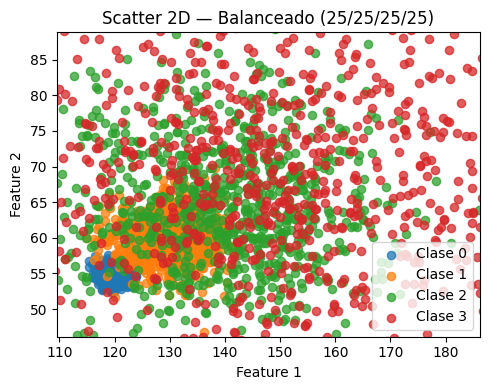

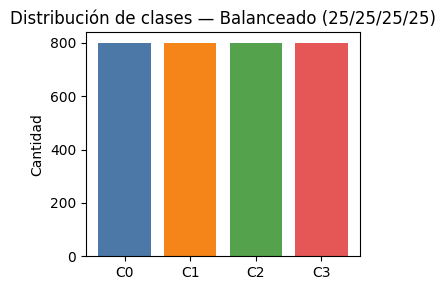

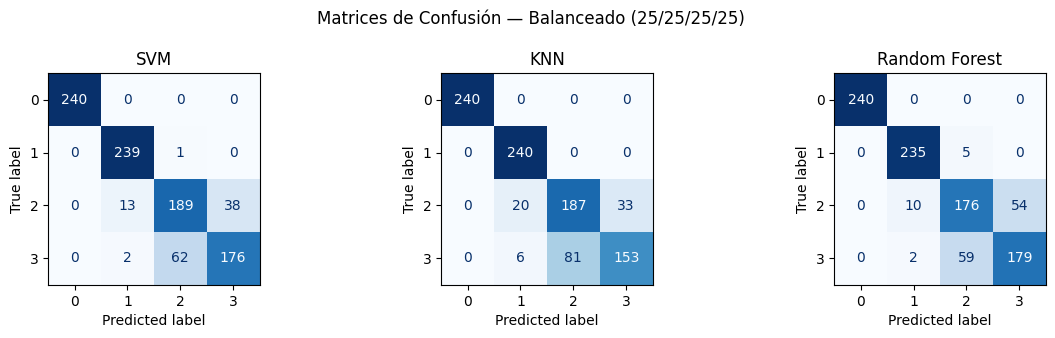

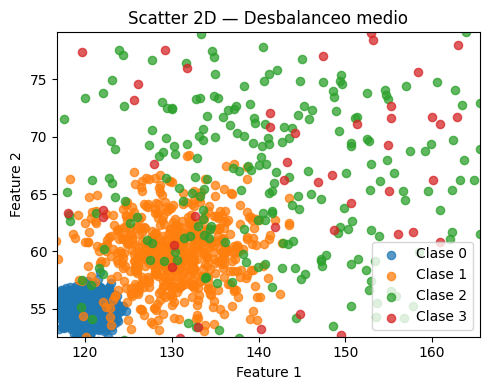

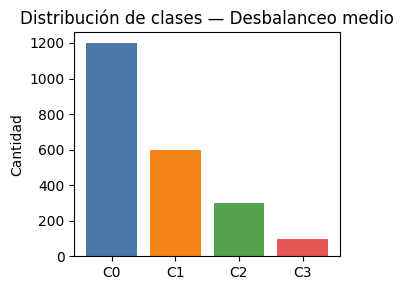

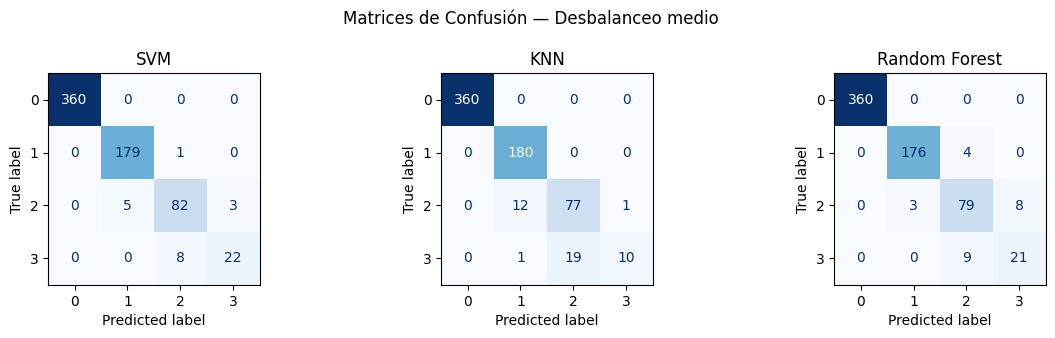

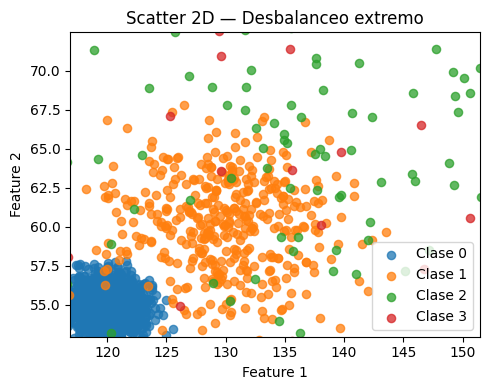

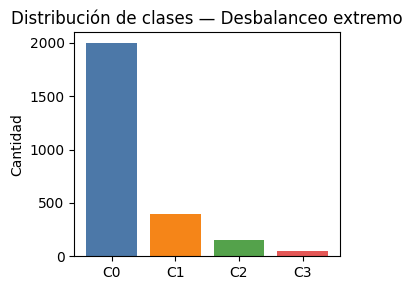

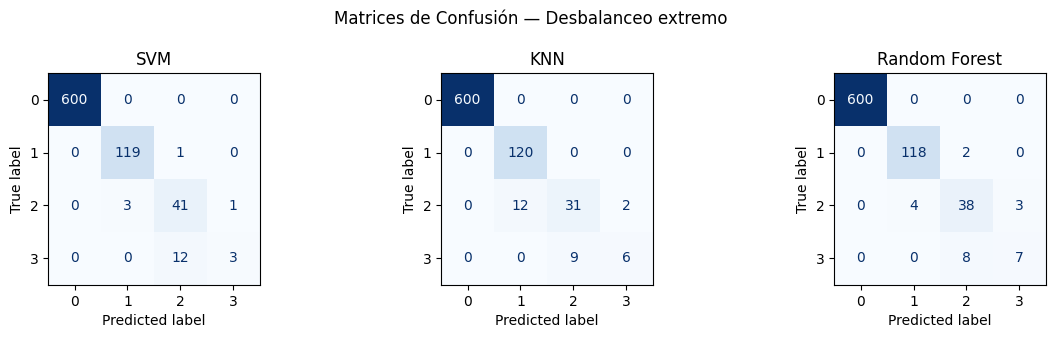

📊 Resultados por escenario y modelo:


,Escenario,Modelo,Accuracy,Precision_macro,Recall_macro,F1_macro,F1_weighted,F1_clase_0,F1_clase_1,F1_clase_2,F1_clase_3
0,Balanceado (25/25/25/25),SVM,0.879,0.878,0.879,0.878,0.878,1.0,0.968,0.768,0.775
1,Balanceado (25/25/25/25),KNN,0.854,0.856,0.854,0.851,0.851,1.0,0.949,0.736,0.718
2,Balanceado (25/25/25/25),Random Forest,0.865,0.863,0.865,0.864,0.864,1.0,0.965,0.733,0.757
3,Desbalanceo medio,SVM,0.974,0.938,0.910,0.922,0.974,1.0,0.984,0.906,0.800
4,Desbalanceo medio,KNN,0.950,0.911,0.797,0.820,0.944,1.0,0.965,0.828,0.488
5,Desbalanceo medio,Random Forest,0.964,0.892,0.889,0.890,0.964,1.0,0.981,0.868,0.712
6,Desbalanceo extremo,SVM,0.978,0.871,0.776,0.782,0.974,1.0,0.983,0.828,0.316
7,Desbalanceo extremo,KNN,0.971,0.859,0.772,0.801,0.968,1.0,0.952,0.729,0.522
8,Desbalanceo extremo,Random Forest,0.978,0.865,0.824,0.838,0.977,1.0,0.975,0.817,0.560



Resumen promedio por escenario:


,Accuracy,F1_macro,F1_weighted,Precision_macro,Recall_macro
Escenario,,,,,
Balanceado (25/25/25/25),0.866,0.864,0.864,0.866,0.866
Desbalanceo extremo,0.976,0.807,0.973,0.865,0.791
Desbalanceo medio,0.963,0.877,0.961,0.914,0.865


In [6]:
# EXPERIMENTO 3 — Desbalanceo con CUATRO CLASES
# Objetivo: analizar cómo el desbalance de clases afecta el
# desempeño de modelos de clasificación (SVM, KNN, Random Forest),
# evaluando cambios en Accuracy y F1-score bajo tres escenarios:
# balanceado, desbalance medio y desbalance extremo.


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# Configuración general
plt.rcParams['axes.grid'] = False
RNG_SEED = 42  # Semilla para asegurar reproducibilidad
rng = np.random.default_rng(RNG_SEED)

#  Parámetros de los datos (idénticos a Exp. 1–2)
# Se mantienen los mismos centros y covarianzas para comparar resultados entre experimentos.
centers = np.array([
    [120, 55, 30, 0.20,  4.0],
    [130, 60, 20, 0.50,  6.0],
    [140, 65, 12, 0.75,  8.0],
    [150, 68,  6, 0.90, 10.0],
], dtype=float)

# Covarianza diagonal: independencia entre variables
cov_base = np.diag([25.0, 9.0, 9.0, 0.02, 0.6])
# Escalas por clase para mantener diferencias en dispersión
scales = np.array([0.3, 1.0, 3.0, 5.0], dtype=float)

def gen_by_counts(counts, centers, scales, cov_base, rng):
    """
    Genera datos sintéticos con 4 clases, según las cantidades definidas
    en el vector 'counts'. Cada clase tiene un número distinto de muestras.
    """
    X_list, y_list = [], []
    for c, (mu, s, n) in enumerate(zip(centers, scales, counts)):
        cov = (s**2) * cov_base
        Xi = rng.multivariate_normal(mu, cov, size=n, check_valid='ignore')
        yi = np.full(n, c, dtype=int)
        X_list.append(Xi)
        y_list.append(yi)
    return np.vstack(X_list), np.concatenate(y_list)

#  Definición de escenarios
# Se varía el número de muestras por clase para simular diferentes grados de desbalance.
scenarios = {
    "Balanceado (25/25/25/25)":   [800, 800, 800, 800],     # 3200 muestras totales
    "Desbalanceo medio":          [1200, 600, 300, 100],    # 2200 totales
    "Desbalanceo extremo":        [2000, 400, 150, 50],     # 2600 totales
}

#  Modelos
# Se mantienen los mismos hiperparámetros que en los experimentos anteriores.
# - SVM (kernel RBF): sensible a variaciones en proporciones de clase.
# - KNN (k=5): afectado por densidad local y tamaño de clase.
# - Random Forest: más estable frente a desbalance gracias al voto agregado.
modelos = {
    "SVM": SVC(kernel='rbf', C=1.0, gamma='scale', random_state=RNG_SEED),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=RNG_SEED)
}

#  Funciones auxiliares para visualización
def scatter_simple(X, y, title):
    """
    Muestra un gráfico de dispersión (solo con las dos primeras variables)
    para visualizar la distribución de las clases.
    """
    x1, x2 = X[:, 0], X[:, 1]
    plt.figure(figsize=(5, 4))
    for c in range(4):
        plt.scatter(x1[y == c], x2[y == c], s=35, alpha=0.75, label=f"Clase {c}")
    # Se recortan los ejes a percentiles para evitar escalas excesivas.
    xlim = np.percentile(x1, [2, 98]); ylim = np.percentile(x2, [2, 98])
    plt.xlim(xlim); plt.ylim(ylim)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.tight_layout()
    plt.show()

def barras_compactas(y, title):
    """
    Dibuja un histograma compacto con el número de muestras por clase.
    Permite visualizar el grado de desbalance entre categorías.
    """
    vals = [np.sum(y == c) for c in range(4)]
    plt.figure(figsize=(3.6, 3.0))
    plt.bar([f"C{c}" for c in range(4)], vals, color=["#4c78a8", "#f58518", "#54a24b", "#e45756"])
    plt.title(title)
    plt.ylabel("Cantidad")
    plt.tight_layout()
    plt.show()

#  Ejecución de los tres escenarios
res_list = []

for scen_name, counts in scenarios.items():
    # (1) Generación del dataset según el escenario de balanceo
    X, y = gen_by_counts(counts, centers, scales, cov_base, rng)

    # (2) Visualizaciones del escenario actual (dispersión + barras)
    scatter_simple(X, y, title=f"Scatter 2D — {scen_name}")
    barras_compactas(y, title=f"Distribución de clases — {scen_name}")

    # (3) División y estandarización de los datos
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=RNG_SEED
    )
    scaler = StandardScaler().fit(X_train)
    X_train_std = scaler.transform(X_train)
    X_test_std = scaler.transform(X_test)

    # (4) Entrenamiento y evaluación de modelos por escenario
    fig, axes = plt.subplots(1, 3, figsize=(12, 3.4))
    fig.suptitle(f"Matrices de Confusión — {scen_name}", fontsize=12)

    for i, (name, modelo) in enumerate(modelos.items()):
        # Clonamos modelo y mantenemos parámetros fijos
        m = type(modelo)(**modelo.get_params())
        if hasattr(m, "random_state"):
            m.set_params(random_state=RNG_SEED)
        m.fit(X_train_std, y_train)
        y_pred = m.predict(X_test_std)

        # Matriz de confusión (clases 0–3)
        cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3])
        ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3]).plot(
            ax=axes[i], cmap="Blues", colorbar=False
        )
        axes[i].set_title(name)
        axes[i].grid(False)

        # Reporte de clasificación detallado
        rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        # Guardamos métricas relevantes (macro, weighted y F1 por clase)
        row = {
            "Escenario": scen_name, "Modelo": name,
            "Accuracy": rep["accuracy"],
            "Precision_macro": rep["macro avg"]["precision"],
            "Recall_macro": rep["macro avg"]["recall"],
            "F1_macro": rep["macro avg"]["f1-score"],
            "F1_weighted": rep["weighted avg"]["f1-score"],
        }
        for c in range(4):
            row[f"F1_clase_{c}"] = rep.get(str(c), {}).get("f1-score", 0.0)
        res_list.append(row)

    plt.tight_layout()
    plt.show()

# Resultados consolidados
# Se construye una tabla con todas las métricas por escenario y modelo.
df_resultados = pd.DataFrame(res_list).round(3)
print("📊 Resultados por escenario y modelo:")
display(df_resultados)

# Promedio global por escenario: mide impacto general del desbalance.
cols_sum = ["Accuracy", "F1_macro", "F1_weighted", "Precision_macro", "Recall_macro"]
df_resumen = df_resultados.groupby("Escenario")[cols_sum].mean().round(3)
print("\nResumen promedio por escenario:")
display(df_resumen)
